#  Generate Tear Sheets with Pyfolio 
* Pyfolio provides dozens of KPI performance tables and graphs to characterize trading strategies.
* It is difficult to override the folder structure so you should simply set results_dir and it will 
create the children in ./plot/temp and then clean the children up when done.
* Do not check in notebooks that uncleared results as they can be quite large.

Processing backtest results in /home/morgan/repos/edge-seeker/zipline-x/results/plots/temp/20241028_132934...
The Benchmark is Date
2008-01-10 00:00:00+00:00    0.000000
2008-01-11 00:00:00+00:00   -0.008068
2008-01-14 00:00:00+00:00    0.008063
2008-01-15 00:00:00+00:00   -0.022013
2008-01-16 00:00:00+00:00   -0.008613
                               ...   
2024-10-14 00:00:00+00:00    0.008178
2024-10-15 00:00:00+00:00   -0.007770
2024-10-16 00:00:00+00:00    0.004346
2024-10-17 00:00:00+00:00    0.000086
2024-10-18 00:00:00+00:00    0.003847
Name: Return, Length: 4223, dtype: float64 results_dir is /home/morgan/repos/edge-seeker/zipline-x/results/plots/temp/20241028_132934, live_date is 2022-01-01
Table saved to ./plots/temp/table_20241029_202551109033.html
Table saved to ./plots/temp/table_20241029_202552637024.html


2024-10-29 20:26:14,821 - INFO - Saving Full Tear Sheet to ./plots/temp
2024-10-29 20:26:17,476 - INFO - Running create_interesting_times_tear_sheet


Plot saved: ./plots/temp/Full Tear Sheet.png
Table saved to ./plots/temp/table_20241029_202617494118.html


2024-10-29 20:27:34,144 - INFO - Saving Interesting Times Tear Sheet to ./plots/temp


Plot saved: ./plots/temp/Interesting Times Tear Sheet.png
Table saved to ./plots/temp/table_20241029_202734599998.html
Table saved to ./plots/temp/table_20241029_202735749282.html
Table saved to ./plots/temp/table_20241029_202741633367.html


2024-10-29 20:27:43,774 - INFO - Saving Position Tear Sheet to ./plots/temp


Plot saved: ./plots/temp/Position Tear Sheet.png


2024-10-29 20:27:46,677 - INFO - Saving TXN Tear Sheet to ./plots/temp


Plot saved: ./plots/temp/TXN Tear Sheet.png
Table saved to ./plots/temp/table_20241029_202834230874.html
Table saved to ./plots/temp/table_20241029_202834236053.html
Table saved to ./plots/temp/table_20241029_202834241865.html
Table saved to ./plots/temp/table_20241029_202834248612.html
Table saved to ./plots/temp/table_20241029_202834417960.html
Table saved to ./plots/temp/table_20241029_202835694030.html


2024-10-29 20:28:53,629 - INFO - Saving Round Trip Tear Sheet to ./plots/temp
2024-10-29 20:28:59,726 - INFO - Aggregated tearsheet saved to /home/morgan/repos/edge-seeker/zipline-x/results/plots/temp/20241028_132934/20241028_132934_full_tearsheet.html


Plot saved: ./plots/temp/Round Trip Tear Sheet.png


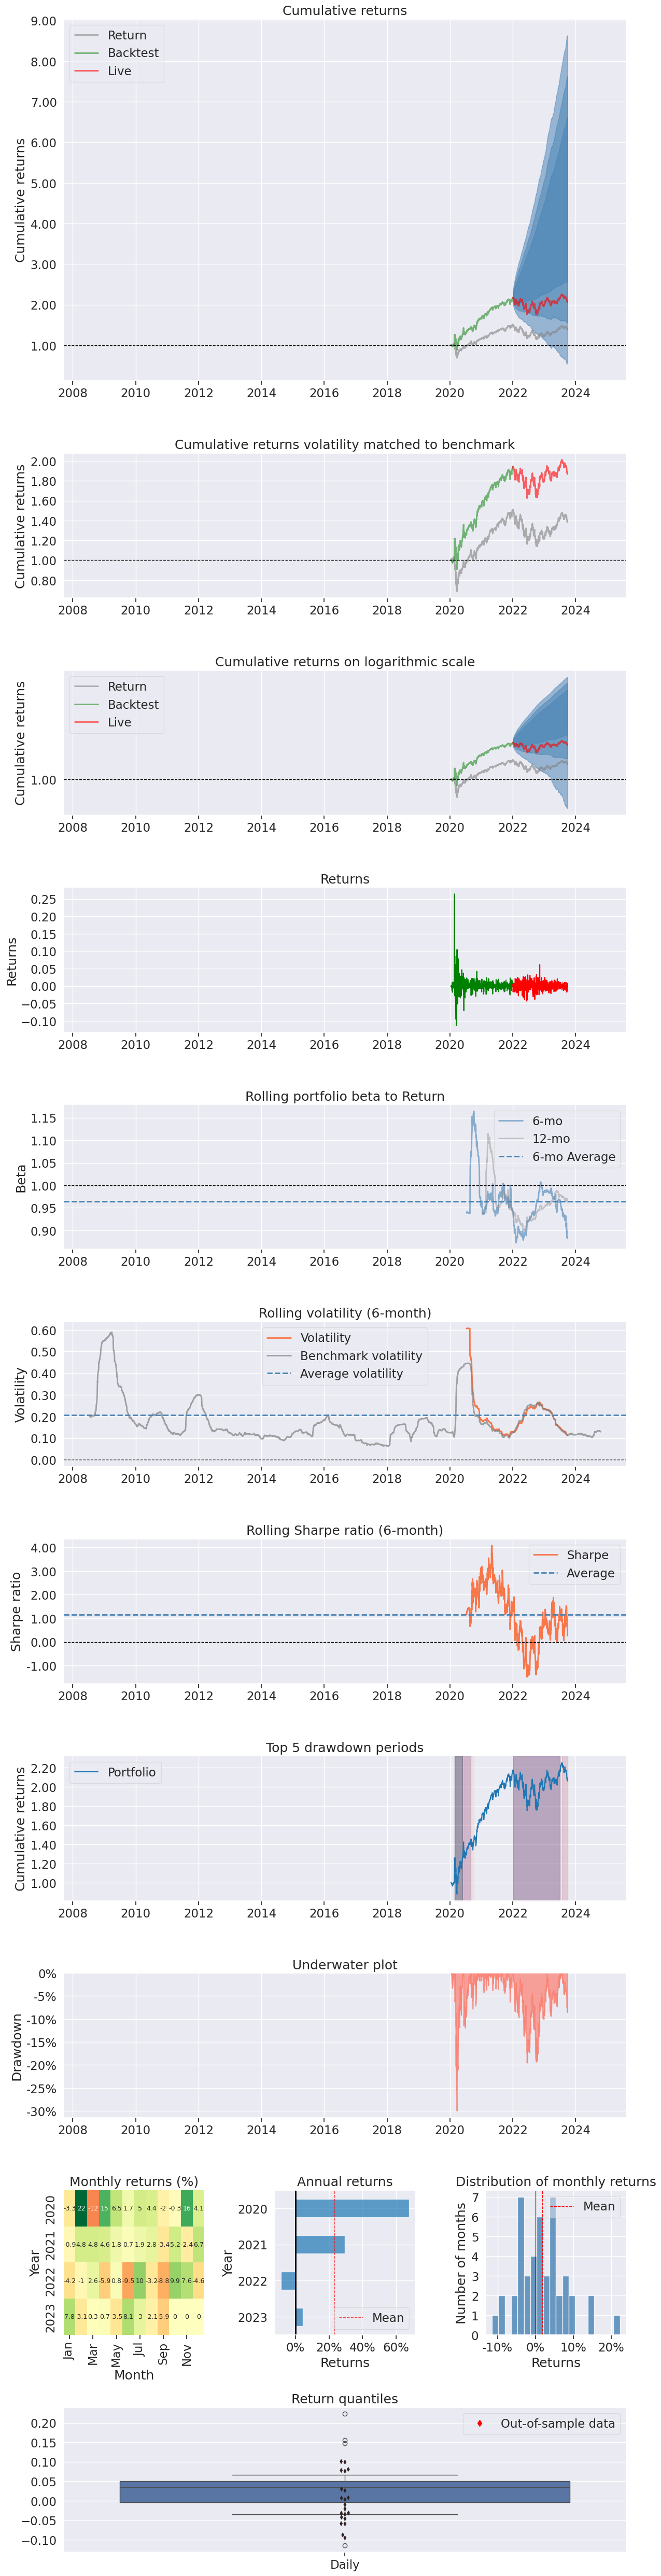

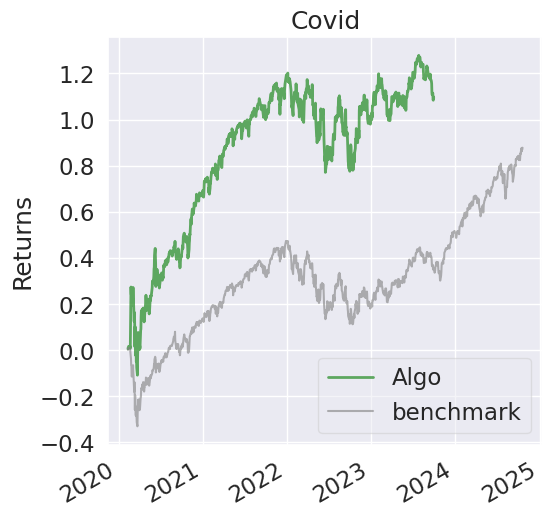

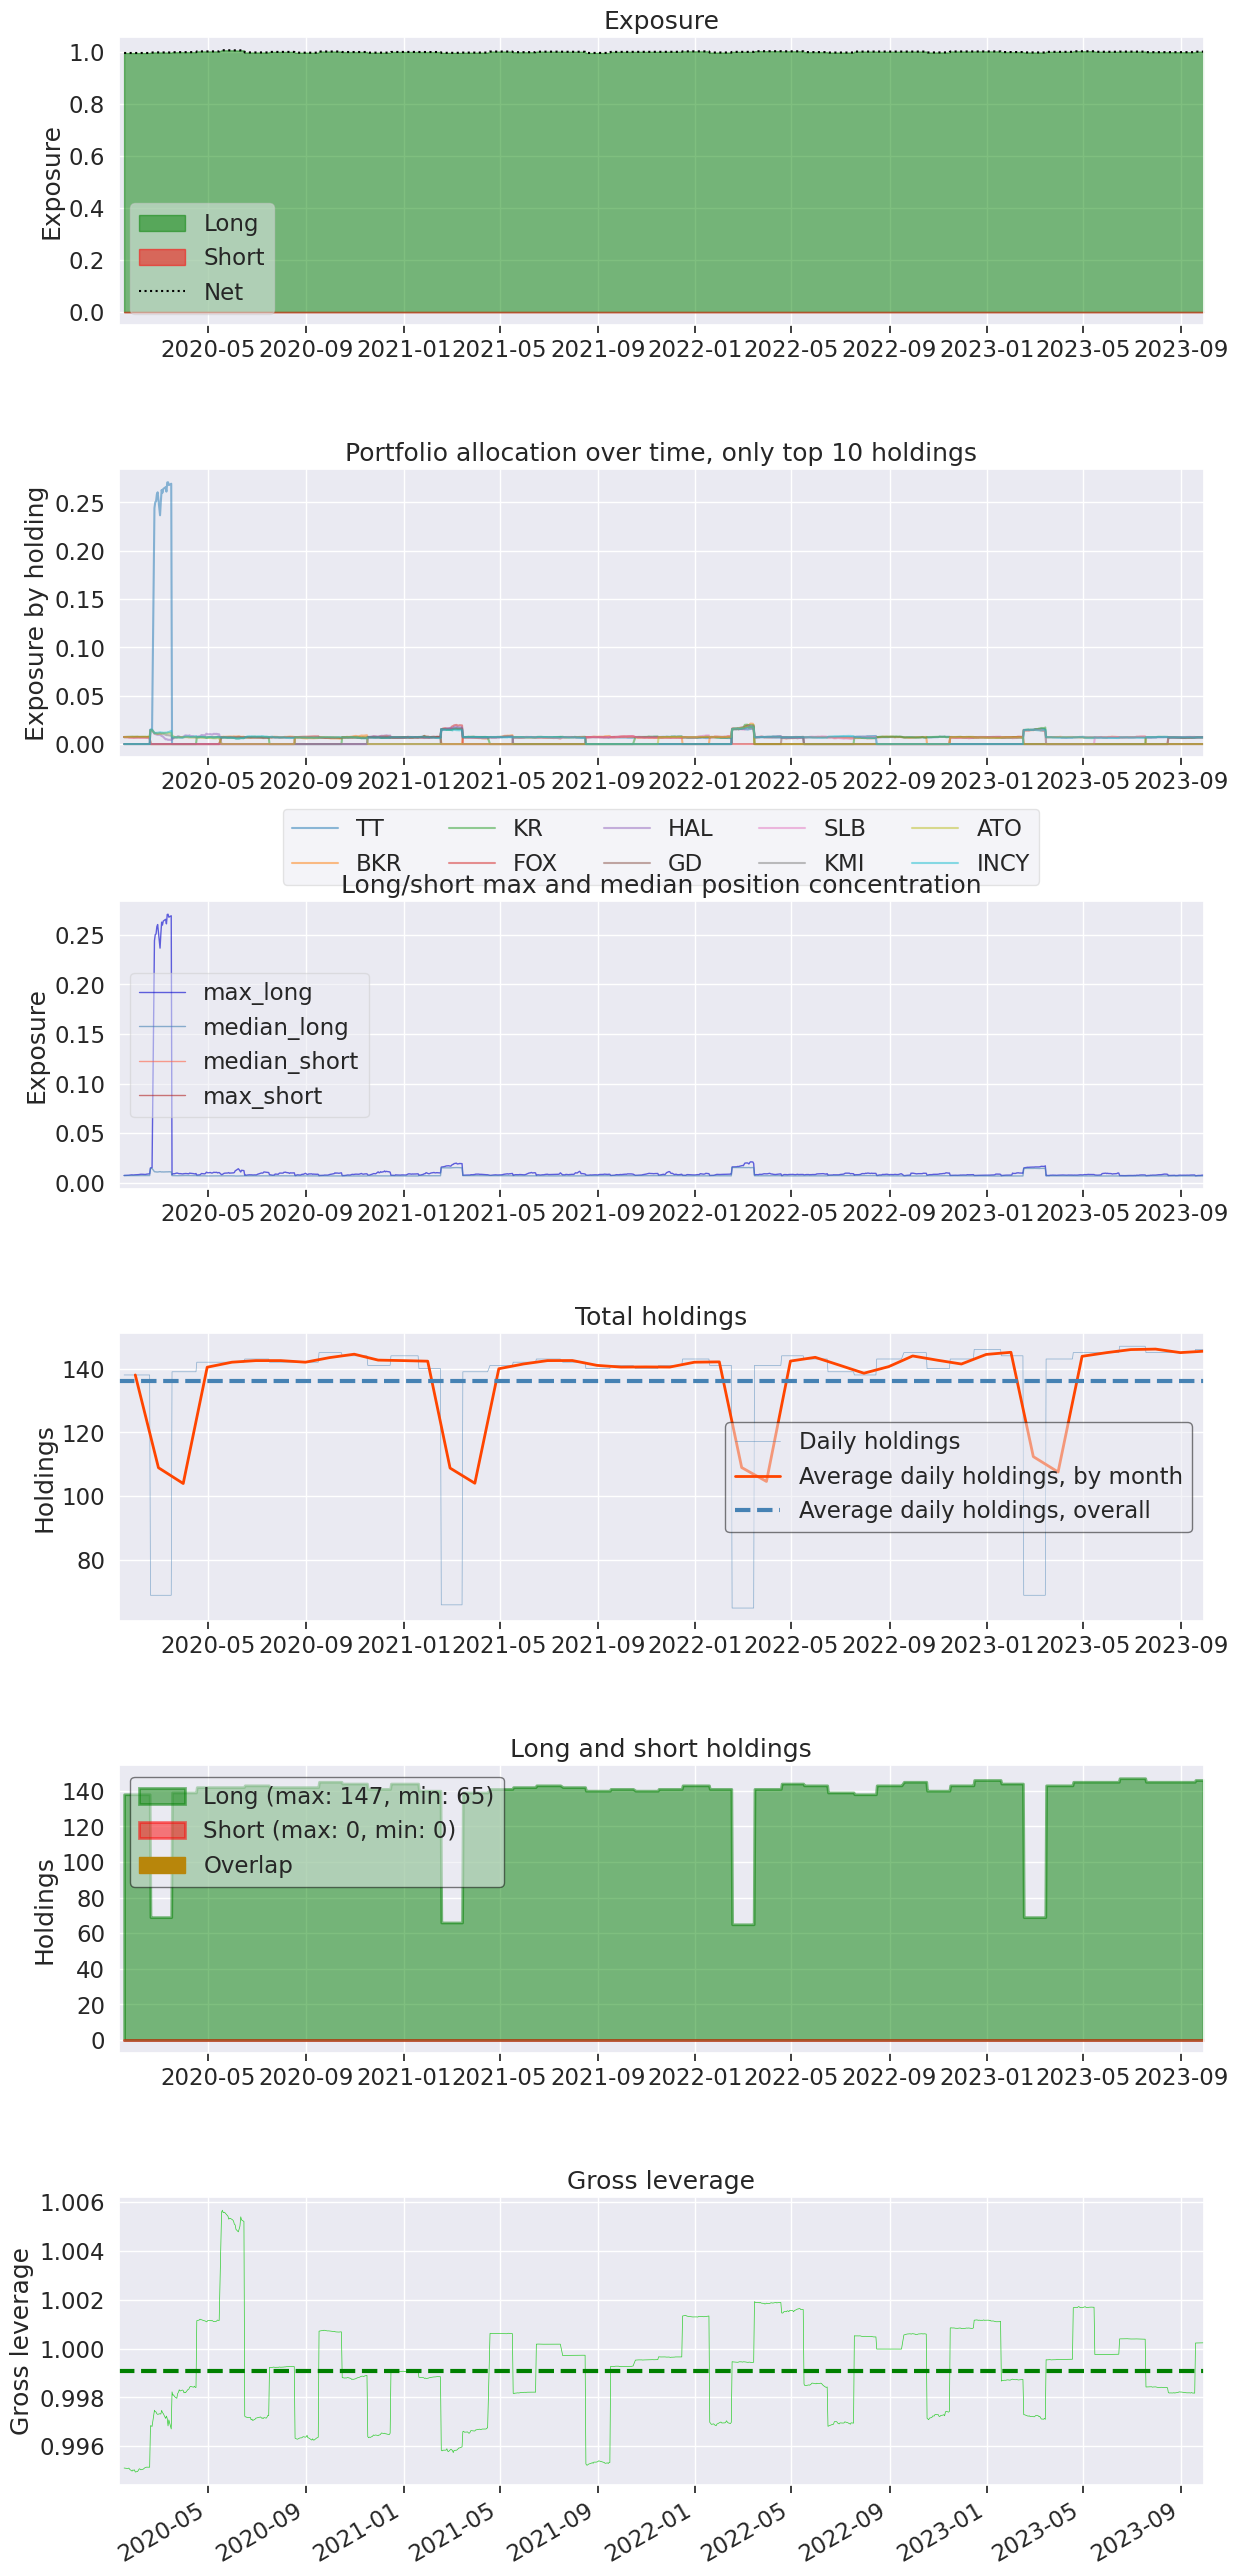

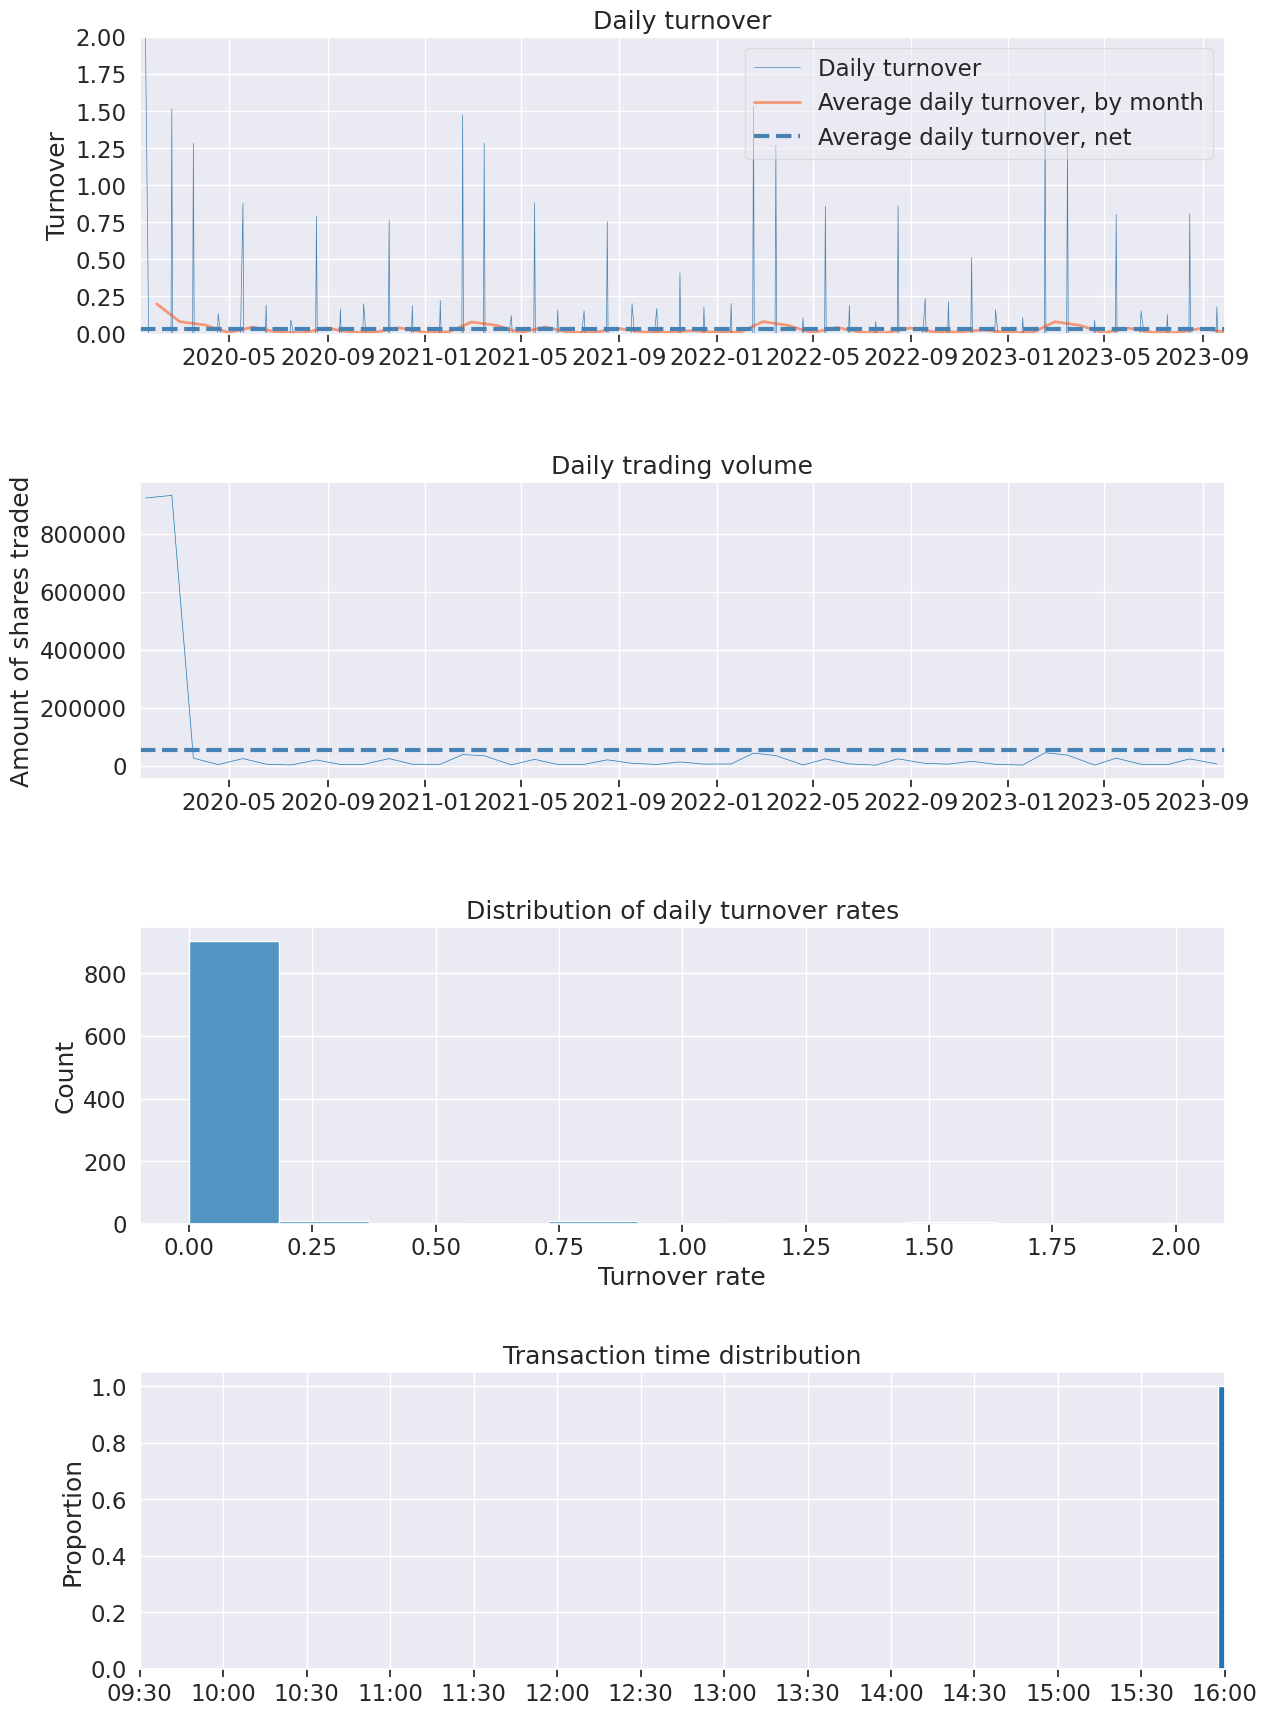

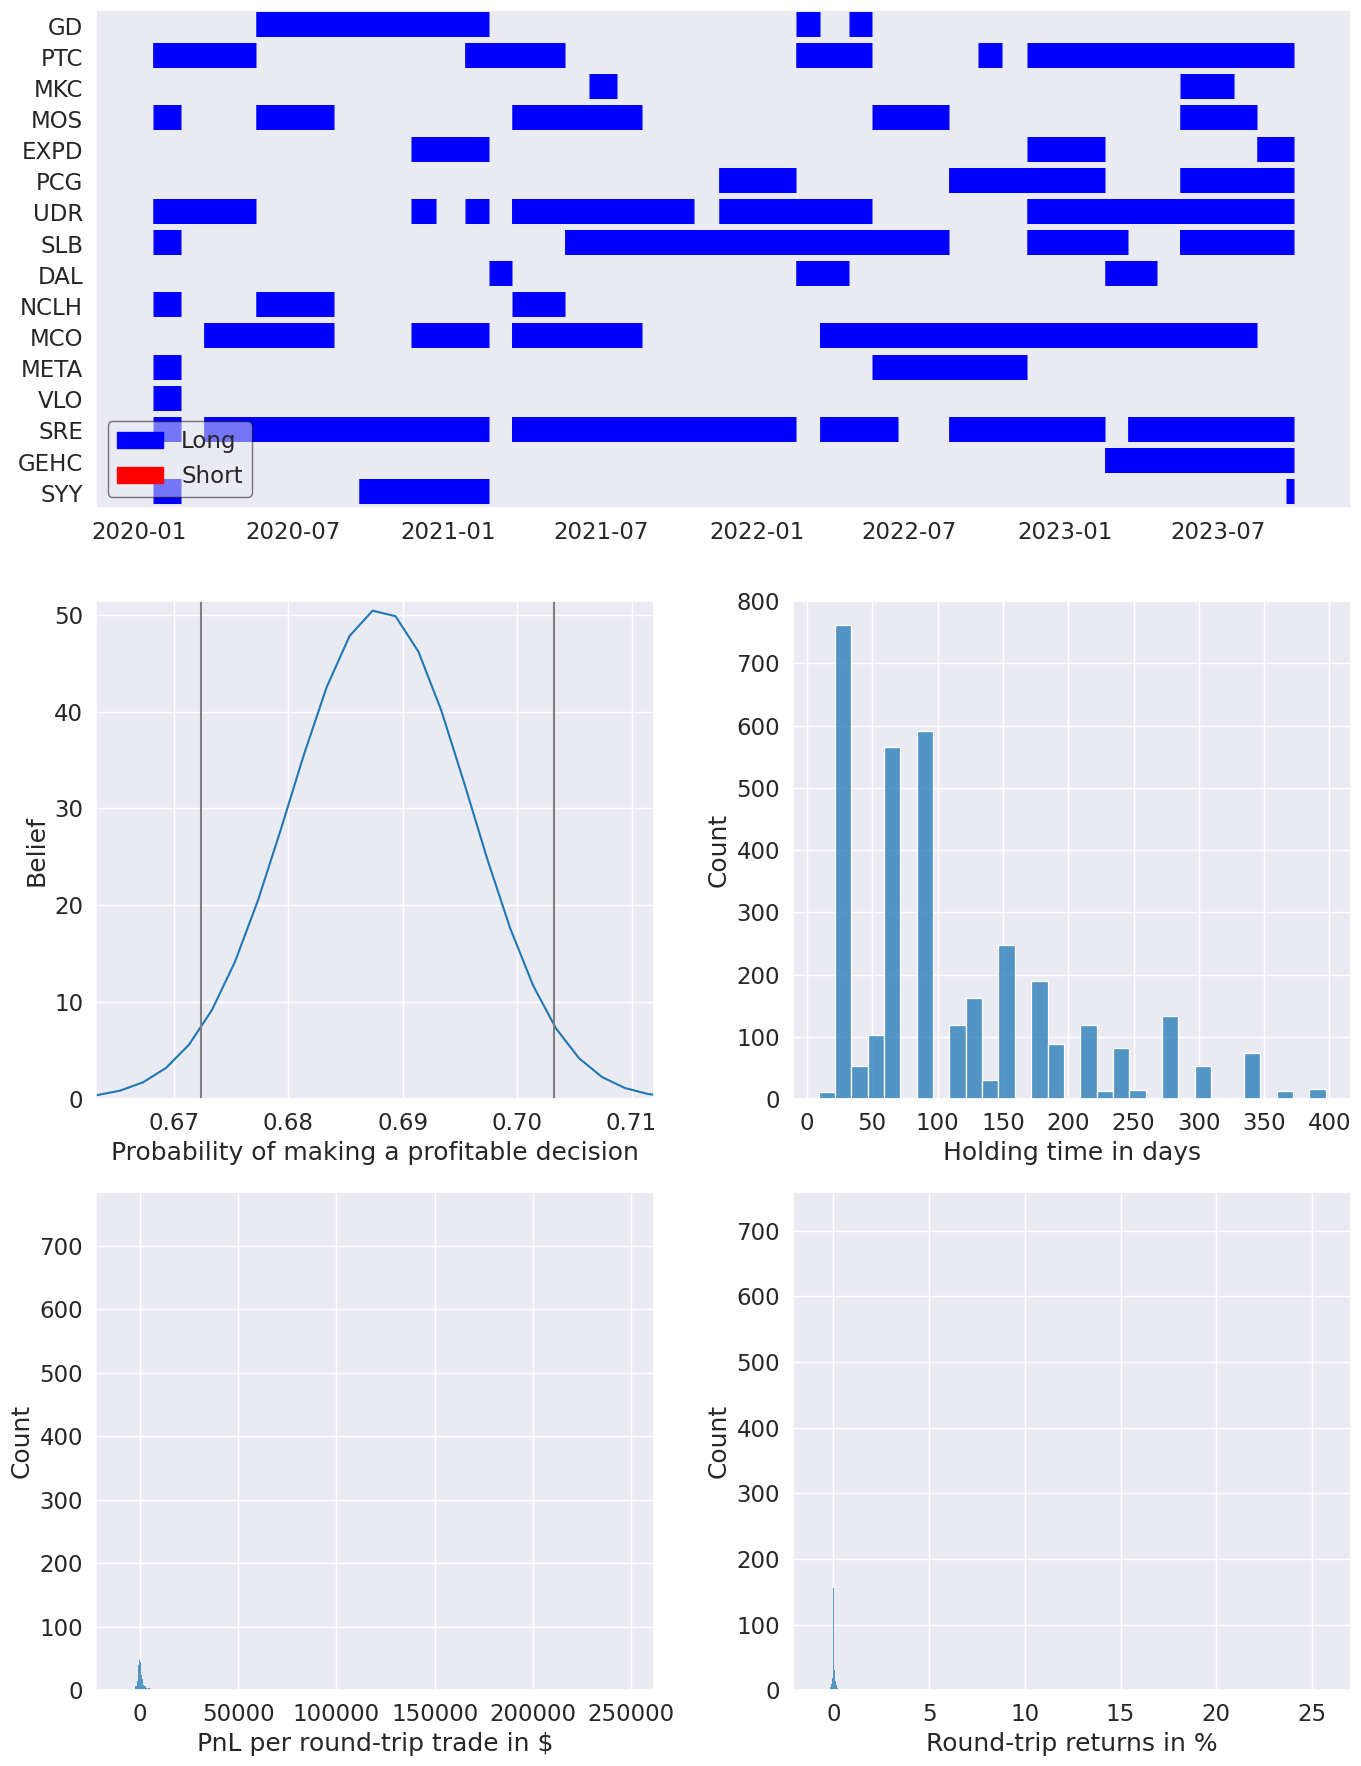

In [9]:
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import pyfolio as pf
import warnings
from utils import (
    get_russell1000_data,
    get_russell2000_data,
    get_sp500_etf_data,
)

warnings.filterwarnings("ignore")


def plotting(results, results_dir, BacktestSettings,benchmark, live_date='2023-01-01'):
    """
    Plot various financial metrics and save results as a tear sheet.

    Parameters:
        results (pd.DataFrame): The backtest results data.
        results_dir (str): Directory where results will be saved.
        benchmark (pd.Series): Benchmark returns to compare against.
        live_date (str): Date when the live trading started.
    """
    print(f'The Benchmark is {benchmark} results_dir is {results_dir}, live_date is {live_date}')
    # Extract performance metrics from the backtest results
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
    
    # Generate and save a full tear sheet using pyfolio
    pf.create_full_tear_sheet(returns,
                              positions=positions,
                              transactions=transactions,
                              benchmark_rets=benchmark,
                              round_trips=True,
                              results_dir=results_dir,
                              live_start_date=live_date,
                              header_rows=BacktestSettings
                              )


def process_backtest_results(results_dir, live_date):
    """
    Process backtest results from a given directory.

    Parameters:
        results_dir (str): Directory containing the backtest results and settings.
    """
    # Load the backtest settings from the JSON file
    settings_file = os.path.join(results_dir, 'BacktestSetting.json')
    if not os.path.exists(settings_file):
        print(f"Settings file not found in {results_dir}. Skipping...")
        return

    with open(settings_file, 'r') as f:
        BacktestSetting = json.load(f)

    # Determine the benchmark data based on the primary index in the settings
    if BacktestSetting['primaryindex'] == "S&P 500":
        benchmark = get_sp500_etf_data(BacktestSetting['start_date'], BacktestSetting['end_date']).fillna(0)
    elif BacktestSetting['primaryindex'] == "Russell 2000":
        benchmark = get_russell2000_data(BacktestSetting['start_date'], BacktestSetting['end_date']).fillna(0)
    elif BacktestSetting['primaryindex'] == "Russell 1000":
        benchmark = get_russell1000_data(BacktestSetting['start_date'], BacktestSetting['end_date']).fillna(0)
    else:
        print(f"Unknown primary index {BacktestSetting['primaryindex']} in {results_dir}. Skipping...").fillna(0)
        return

    # Load the results from the HDF5 file
    results_file = os.path.join(results_dir, 'results.h5')
    if not os.path.exists(results_file):
        print(f"Results file not found in {results_dir}. Skipping...")
        return

    results = pd.read_hdf(results_file, 'results')

    # Generate and save the plots and tear sheet    
    plotting(results, results_dir, BacktestSetting, benchmark, live_date)



def main():
    """
    Main function to process all backtest results in the specified base directory.
    """
    base_dir = os.path.expanduser("~/repos/edge-seeker/zipline-x/results/plots/temp")
    live_date ='2022-01-01'
    include = ['20241028_132934']
    # Loop through all directories in the base directory
    for dir_name in os.listdir(base_dir):
        if any(re.search(pattern, dir_name) for pattern in include):  # Use regex to match patterns in the include list
            results_dir = os.path.join(base_dir, dir_name)
            if os.path.isdir(results_dir):  # Process only directories
                print(f"Processing backtest results in {results_dir}...")
                try:                    
                    process_backtest_results(results_dir, live_date=live_date)
                except Exception as e:
                    print(e)


if __name__ == "__main__":
    main()

